In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [3]:
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis

In [4]:
def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    ##note li zhou: also cite Converted from MATLAB script at http://billauer.co.il/peakdet.html
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]

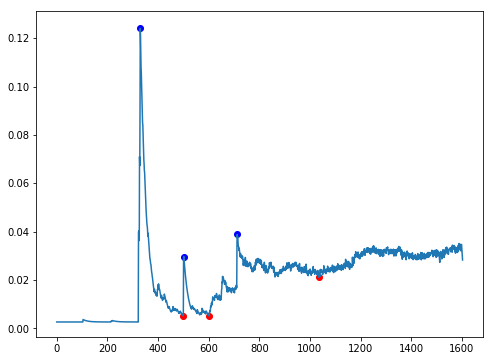

In [5]:
# need to run the above def peakdet
from matplotlib.pyplot import plot, scatter, show
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

SelectCell = 2

Cal_temp_C = np.load('Cal_temp_C.npy')
idx_components = np.load('cnm.estimates.idx_components.npy')
Cal_temp_C = Cal_temp_C[idx_components] #select good trace

x = Cal_temp_C[:,:]#slicing the pharmacology time, sampling at 1 Hz. 
standardized_X = preprocessing.normalize(x,norm = "l2", axis=1) # row norm, 'L2' not '12'

series = standardized_X[SelectCell,:]

maxtab, mintab = peakdetect(y_axis=series, x_axis = None, lookahead = 5, delta=0.01)

fig,ax = plt.subplots(figsize=(8,6))
plot(series)
# scatter(maxtab[:,0], maxtab[:,1], color='blue')
# scatter(mintab[:,0], mintab[:,1], color='red')
scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')
scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red')
# plt.savefig('peaktest.png',dpi=300)
show()
# anp=np.array(maxtab)  
# anp

In [6]:
def calcium_peaks(data):
    ls = []
    row,col = data.shape
    for i in range(0,row):
        row_data=data[i,:]
        maxtab, mintab = peakdetect(y_axis=row_data, x_axis = None, lookahead = 1, delta=0.01)
        ls.append(maxtab)

    return ls

In [7]:

Cal_temp_C = np.load('Cal_temp_C.npy')
idx_components = np.load('cnm.estimates.idx_components.npy')
Cal_temp_C = Cal_temp_C[idx_components] #select good trace

x = Cal_temp_C[:,:]#slicing the pharmacology time, sampling at 1 Hz. 
standardized_X = preprocessing.normalize(x,norm = "l2", axis=1) # row norm, 'L2' not '12'

testdata = standardized_X
testresult = calcium_peaks(testdata)
    
print(len(testresult))
testresult[0]

82


[[440, 0.1371277398759877],
 [447, 0.12473597856741288],
 [528, 0.04161717135765383],
 [568, 0.062038885768240855],
 [636, 0.03641695824088606],
 [768, 0.03626026982106845],
 [803, 0.030384586269562034]]

In [8]:
peaks = np.array(testresult)
print(peaks.shape)
newpeaks = np.delete(peaks,[8,49])
print(newpeaks.shape)
np.save('031542020gw20(3.13)_fluo8_slice2_EventTimePoint',newpeaks)

(82,)
(80,)


In [9]:
#summarize the calcium events in the first 300 s, record cell number, and total events

newpeaks = np.load('031542020gw20(3.13)_fluo8_slice2_EventTimePoint.npy',allow_pickle=True)
print(newpeaks.shape)
print(type(newpeaks[0]))

before = []
after = []
for x in range(0,len(newpeaks)):
    i0_300 = 0
    for i in testresult[x]:

        if 0<i[0]<300:
            i0_300 += 1
    before.append(i0_300)

print("total events:",np.sum(before))
print("total cells:",len(before))
print("average events per cell:",np.mean(before))


(80,)
<class 'list'>
total events: 132
total cells: 80
average events per cell: 1.65
